In [2]:
pip install torch torchvision matplotlib pandas scikit-learn


  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   ------------------- -------------------- 5.2/11.0 MB 21.2 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/11.0 MB 22.3 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.0 MB 12.3 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.0 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 11.3 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import ImageFile

In [6]:
# Define directory paths
train_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"
val_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\val"
test_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test"

In [7]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
# Define transformations for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip images for augmentation
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ]),
}

In [11]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

# Create data loaders with a defined batch size
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Display the sizes of the datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Check classes in the training dataset
classes = os.listdir(train_dir)
print(f"Classes found: {len(classes)}")
print(classes)

Number of training samples: 9246
Number of validation samples: 829
Number of test samples: 506
Classes found: 2
['fractured', 'not fractured']


In [12]:
# Define the Custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # RGB input
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjust based on image size after pooling
        self.fc2 = nn.Linear(256, 1)  # Binary classification output

    def forward(self, x):
        # Forward pass through convolutional layers and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Activation for first fully connected layer
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification
        return x

In [13]:
# Set device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the specified device
model = CustomCNN().to(device)

In [14]:
# Define the loss function and optimizer
criterion = nn.BCELoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be tuned

In [15]:
# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)  # Move data to GPU
            optimizer.zero_grad()  # Zero gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs.view(-1), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()  # Accumulate loss

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 0.6141, Val Loss: 0.6441
Epoch [2/10], Train Loss: 0.2590, Val Loss: 0.3413
Epoch [3/10], Train Loss: 0.1020, Val Loss: 0.2873
Epoch [4/10], Train Loss: 0.0426, Val Loss: 0.1810
Epoch [5/10], Train Loss: 0.0299, Val Loss: 0.1220
Epoch [6/10], Train Loss: 0.0196, Val Loss: 0.0964
Epoch [7/10], Train Loss: 0.0127, Val Loss: 0.0499
Epoch [8/10], Train Loss: 0.0091, Val Loss: 0.0616
Epoch [9/10], Train Loss: 0.0057, Val Loss: 0.0286
Epoch [10/10], Train Loss: 0.0063, Val Loss: 0.0461


               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       238
not fractured       0.98      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



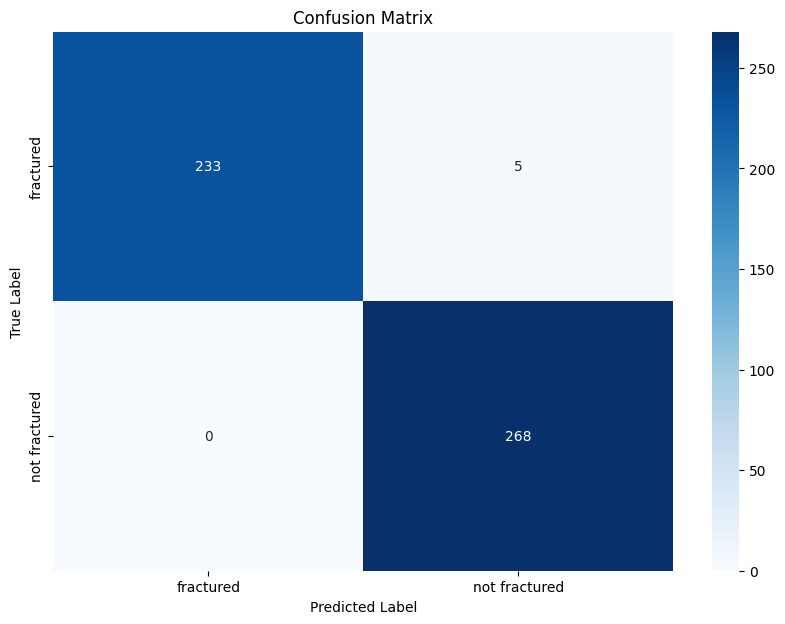

In [17]:
import seaborn as sns

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs.view(-1) > 0.5).float()  # Convert probabilities to binary predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have your test_loader already defined
evaluate_model(model, test_loader)